In [88]:
from src.utils.data_utils import load_dataframe_from_csv
from src.data.dataloader import load_initial_dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# What makes a movie win an award?

With the subquestions stated in our README, this `results.ipynb` shows how we are able to have a quality dataset that will serve for our data analysis.

First, we fetch our Oscars award winning dataset of actors, and our dataset that is enriched.


In [89]:
movie = load_dataframe_from_csv('movie_cmu.csv')
character = load_dataframe_from_csv('character.csv')
plot_summaries = load_dataframe_from_csv('plot_summaries.csv')
tvtropes = load_dataframe_from_csv('tvtropes.csv')
name_clusters = load_dataframe_from_csv('name_clusters.csv')
oscar_winning_films = load_dataframe_from_csv('oscar_winning_films_ids.csv')
oscar_winning_actors = load_dataframe_from_csv('oscar_winning_actors.csv')
oscar_winning_actresses = load_dataframe_from_csv('oscar_winning_actresses.csv')
oscar_supporting_actors = load_dataframe_from_csv('oscar_winning_supporting_actors.csv')
oscar_supporting_actresses = load_dataframe_from_csv('oscar_winning_supporting_actresses.csv')
extended_films = load_dataframe_from_csv('film_2015_2024.csv')
academy_award_winning_films = load_dataframe_from_csv('acedemy_award_winning_films')
winning_actors_info = load_dataframe_from_csv('winning_actors_information.csv')

Here, we can see that we fetched all Oscars winning actors and actresses, and that gives us a relevant sample for our further analysis


In [90]:
print("More information about the oscar winning actors")

print(winning_actors_info.value_counts())

More information about the oscar winning actors
page_id   wikidata_id  actor                sexLabel  nativeLanguageLabel  countryOfCitizenshipLabel  ethnicGroupLabel  
11181     Q40912       Frank Sinatra        male      American English     United States of America   Italian Americans     1
13717     Q1033016     Halle Berry          female    English              United States of America   African Americans     1
20647767  Q103343      Jennifer Connelly    female    American English     United States of America   Ashkenazi Jews        1
12684530  Q189490      Jennifer Lawrence    female    English              United States of America   French Americans      1
8694199   Q229254      Octavia Spencer      female    English              United States of America   African Americans     1
3741746   Q147077      Emma Stone           female    English              United States of America   Swedish Americans     1
1086198   Q150482      J. K. Simmons        male      English              

We plot the age of the oscar winning actors and actresses, we could 

/var/folders/fv/f56ltf0x04g0yp86bf3wx6w80000gn/T/ipykernel_41215/2466846804.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_characters['Actor age at movie release'] = filtered_characters['Actor age at movie release'].dropna()


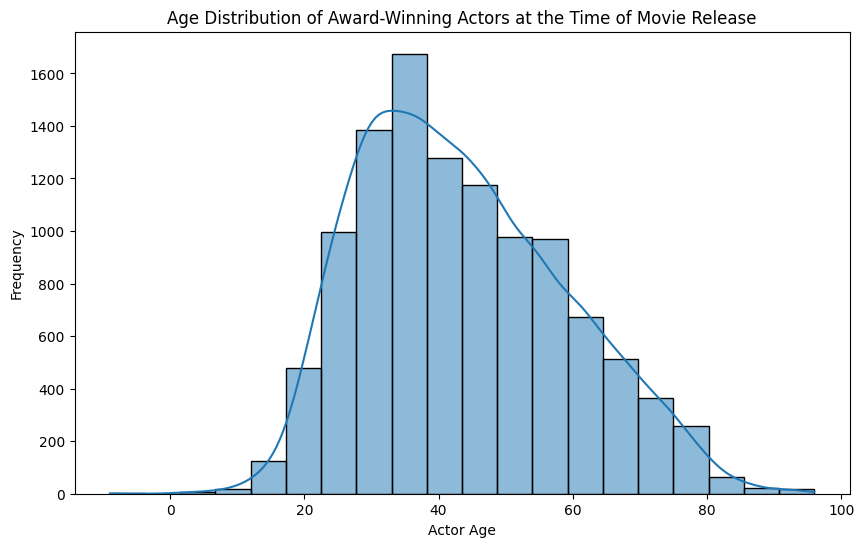

In [79]:
# Filtering the characters DataFrame to include only award-winning actors
filtered_characters = character[character['Actor name'].isin(winning_actors_info['actor'])].copy()

# Ensure 'filtered_characters' is a proper copy to avoid SettingWithCopyWarning
filtered_characters.dropna(subset=['Actor age at movie release'], inplace=True)

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(filtered_characters['Actor age at movie release'], bins=20, kde=True)
plt.title('Age Distribution of Award-Winning Actors at the Time of Movie Release')
plt.xlabel('Actor Age')
plt.ylabel('Frequency')
plt.show()

By plotting this age distribution, we can see that most winning actors are middle-age with 30-40 years old.

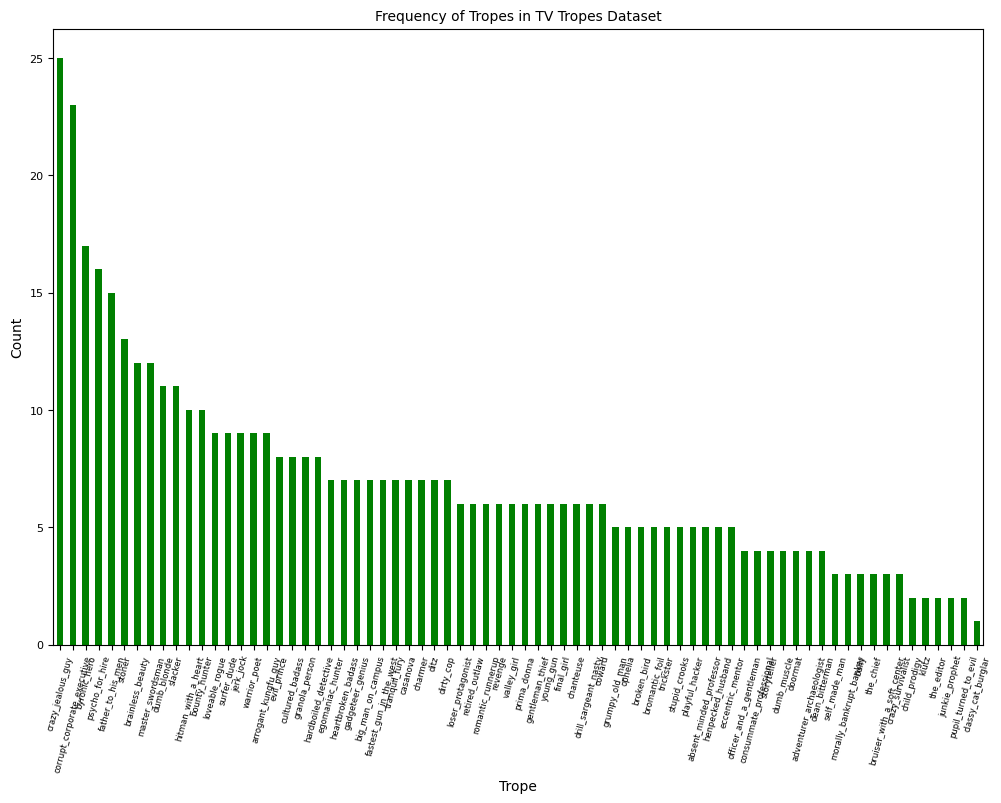

In [87]:
trope_counts = tvtropes['Trope'].value_counts()
plt.figure(figsize=(12, 8))
trope_counts.plot(kind='bar', color='green')
plt.xlabel('Trope', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Frequency of Tropes in TV Tropes Dataset', fontsize=10)
plt.xticks(rotation=75, fontsize=6)
plt.yticks(fontsize=8)
plt.show()

Here is the bar plot of most common genres in award-winning films.

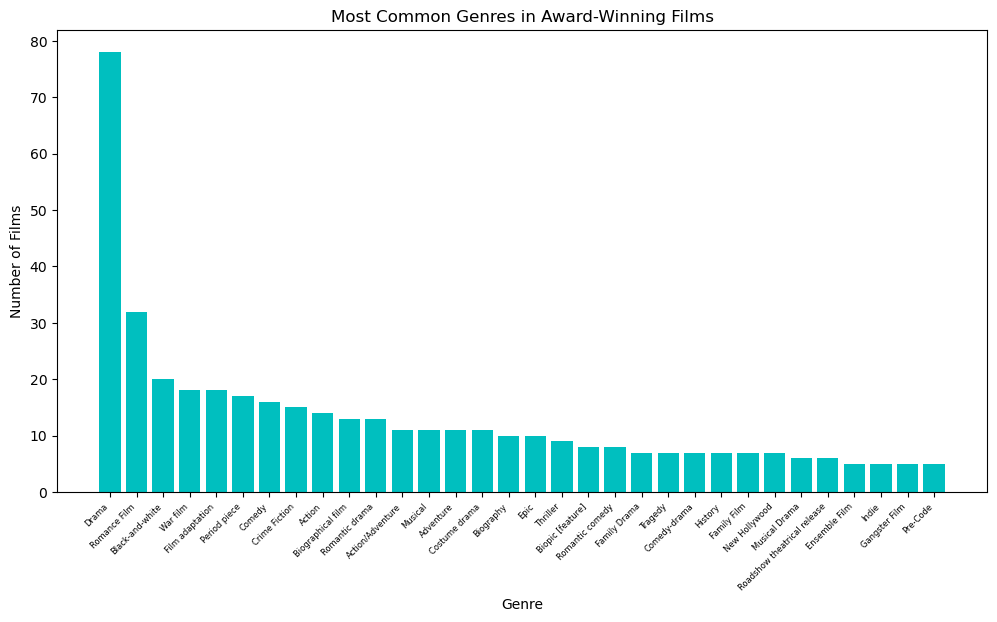

In [222]:
from collections import Counter 

oscar_films_ids = oscar_winning_films['Page ID']
oscar_films = movie[movie['Wikipedia movie ID'].isin(oscar_winning_films['Page ID'])]

# Flatten the list of genres and count occurrences
all_genres = [genre for sublist in oscar_films['Movie genres'].str.split(', ') for genre in sublist]
genre_counts = Counter(all_genres)

# Convert the counts to a DataFrame for easier plotting
genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])

# Filter genres with at least 20 movies
genre_counts_df = genre_counts_df[genre_counts_df['Count'] >= 5]

# Plot the genre counts as a bar chart
plt.figure(figsize=(12, 6))
genre_counts_df.sort_values(by='Count', ascending=False, inplace=True)
plt.bar(genre_counts_df['Genre'], genre_counts_df['Count'], color='c')

plt.xticks(rotation=45, ha='right', fontsize=6)
plt.title('Most Common Genres in Award-Winning Films')
plt.ylabel('Number of Films')
plt.xlabel('Genre')
plt.show()

We can see that we have a lot more drama movies than other genre of movies, we have then to balance the data.

Here is the distribution of review score, primal for our comparison with reviews.

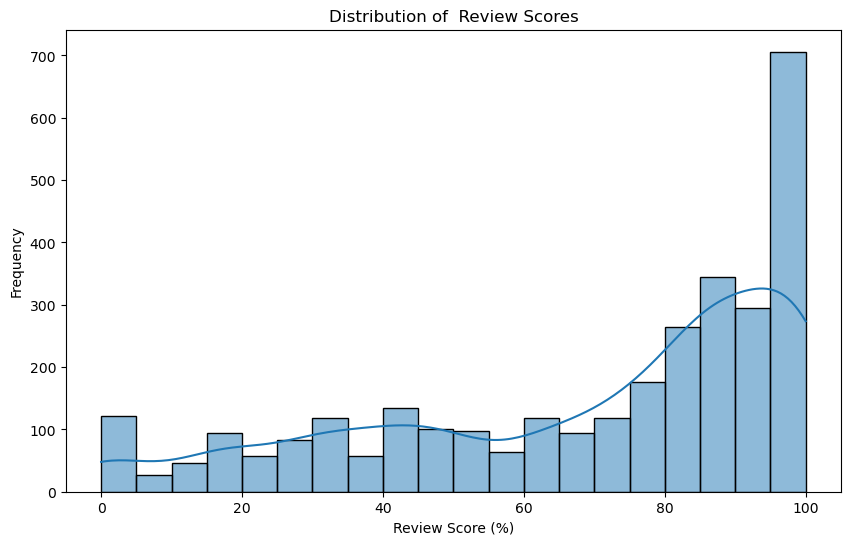

In [223]:
# Extract the first review score from the reviewScores column

# Drop rows with missing review scores
review_scores = extended_films['reviewScores'].dropna().apply(lambda x: [score for score in eval(x) if score != ['']]).dropna()
review_scores = review_scores.apply(lambda x: x[0] if len(x) > 0 else None).dropna()

# Convert the review scores to numeric values, ignoring errors
review_scores = pd.to_numeric(review_scores.str.replace('%', ''), errors='coerce').dropna()

# Plot the distribution of review scores
plt.figure(figsize=(10, 6))
sns.histplot(review_scores, bins=20, kde=True)
plt.title('Distribution of  Review Scores')
plt.xlabel('Review Score (%)')
plt.ylabel('Frequency')
plt.show()

The review scores are clearly going towards the 100%, but this can be because we are using the dataset of award-winning films.

Here is the sentiment compound distribution of plot summaries.

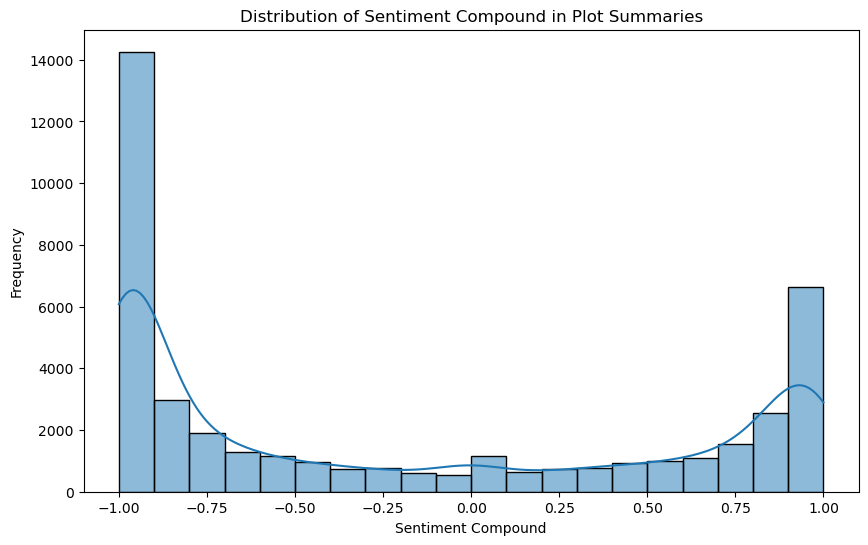

In [224]:
# Plot the distribution of sentiment compound
plt.figure(figsize=(10, 6))
sns.histplot(plot_summaries['sentiment_compound'], bins=20, kde=True)
plt.title('Distribution of Sentiment Compound in Plot Summaries')
plt.xlabel('Sentiment Compound')
plt.ylabel('Frequency')
plt.show()

Here, using the CMU dataset, we apply some sentiment analysis from the NLTK corpus. Hence we can see here that most of plot summaries are more negative (-1) than positive (+1).

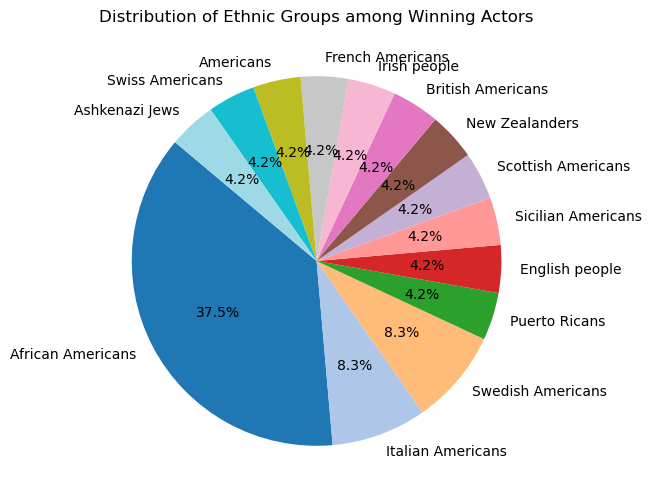

In [225]:
# Drop rows with missing ethnicGroupLabel
ethnic_group_counts = winning_actors_info['ethnicGroupLabel'].dropna().value_counts()

# Plotting the pie chart
plt.figure(figsize=(10, 6))
ethnic_group_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, cmap='tab20')
plt.title('Distribution of Ethnic Groups among Winning Actors')
plt.ylabel('')  # Hide the y-label
plt.show()

By using the winning actors dataset, we can see the ethnicity distribution of actors. Hence, we can see that ther is a strong proportion of African Americans.  